# SVM

## Load Data

In [1]:
import pandas as pd

# Load the provided data files
file_path_neg = 'C:/Users/ddes2/Desktop/桌面/BML/Assignment_3/TVD_neg.csv'
file_path_pos = 'C:/Users/ddes2/Desktop/桌面/BML/Assignment_3/TVD_pos.csv'

negative_data = pd.read_csv(file_path_neg)
positive_data = pd.read_csv(file_path_pos)

# Display the first few rows of each dataset for review
negative_data_head = negative_data.head()
positive_data_head = positive_data.head()

negative_data_head, positive_data_head

(     name  0-hydrophobic  0-positive  0-negative  0-polar  0-charged  0-small  \
 0  Q2RBM4              1           0           0        1          0        1   
 1  Q2RBM4              0           0           1        1          1        1   
 2  Q2RBM4              0           0           0        1          0        1   
 3  Q2RBM4              1           0           0        0          0        0   
 4  Q2RBM4              1           0           0        0          0        0   
 
    0-tiny  0-aliphatic  0-aromatic  ...  30-hydrophobic  30-positive  \
 0       0            0           0  ...               1            0   
 1       0            0           0  ...               1            0   
 2       0            0           0  ...               0            0   
 3       0            1           0  ...               1            0   
 4       0            0           1  ...               1            0   
 
    30-negative  30-polar  30-charged  30-small  30-tiny  30-aliph

Elbow Plot 決定群數

c:\Users\ddes2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ddes2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ddes2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ddes2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ddes2\anaconda3\Lib\site-packages\sklearn\clust

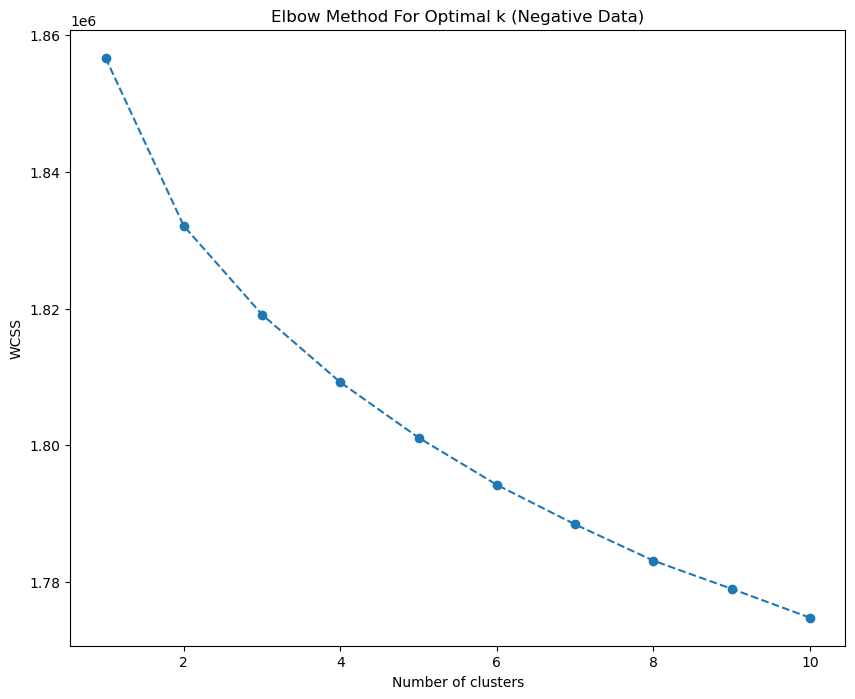

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Drop the unnecessary part
negative_data_numeric = negative_data.drop(columns=['name'])

# Function to calculate the sum of squared distances for different number of clusters
def calculate_wcss(data):
    wcss = []
    for i in range(1, 11):
        kmeans= KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(negative_data_numeric)
        wcss.append(kmeans.inertia_)
    return wcss

# Prepare data for KMeans (drop the 'name' column as it's not needed for clustering)
X_neg = negative_data_head.drop('name', axis=1)

# Calculate WCSS for different number of clusters
wcss_neg = calculate_wcss(X_neg)

# Plot the elbow graph
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss_neg, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k (Negative Data)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [3]:
optimal_k = 3
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans_optimal.fit_predict(negative_data_numeric)

c:\Users\ddes2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
negative_data['Cluster'] = clusters
print(negative_data.head())


     name  0-hydrophobic  0-positive  0-negative  0-polar  0-charged  0-small  \
0  Q2RBM4              1           0           0        1          0        1   
1  Q2RBM4              0           0           1        1          1        1   
2  Q2RBM4              0           0           0        1          0        1   
3  Q2RBM4              1           0           0        0          0        0   
4  Q2RBM4              1           0           0        0          0        0   

   0-tiny  0-aliphatic  0-aromatic  ...  30-positive  30-negative  30-polar  \
0       0            0           0  ...            0            0         0   
1       0            0           0  ...            0            0         0   
2       0            0           0  ...            0            1         1   
3       0            1           0  ...            0            0         0   
4       0            0           1  ...            0            0         0   

   30-charged  30-small  30-tiny  30-a

In [5]:
samples_per_cluster = len(positive_data) // 3
balanced_neg_data = negative_data.groupby('Cluster').apply(lambda x: x.sample(n=samples_per_cluster, random_state=42)).reset_index(drop=True)
combined_data = pd.concat([positive_data, balanced_neg_data], ignore_index=True)
combined_data['Label'] = [1 if i < len(positive_data) else 0 for i in range(len(combined_data))]


In [6]:
len(balanced_neg_data)

4959

拆分數據集

In [7]:
from sklearn.model_selection import train_test_split

# define characteristics and features
X = combined_data.drop(columns=['name', 'Cluster', 'Label'])
y = combined_data['Label']  # label
# divide dataset as training data and testing data
# test_size: the proportion test data/all data
#  random_state: you can get the same result at every time you split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42) # 1/9 ≈ 11.11%
X_train.shape, X_val.shape, X_test.shape # (SAMPLES, FEATURE)


((7935, 310), (992, 310), (992, 310))

## Model Building

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Instantiate the SVM model
svm_model = SVC(probability=True)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10)

# Calculate average score from cross-validation
avg_cv_score = cv_scores.mean()

# Print the average score
print("Average 10-Fold CV Score: {:.2f}".format(avg_cv_score))

# You can also fit the model on the entire training set if you need to make predictions later
# svm_model.fit(X_train, y_train)


Average 10-Fold CV Score: 0.63


In [10]:
svm_model.fit(X_train, y_train)
# 在驗證集和測試集上評估模型效果

y_val_pred = svm_model.predict(X_val)
y_test_pred = svm_model.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Helper function to calculate sensitivity and specificity
def calc_sens_spec(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
    return sensitivity, specificity

# Calculate metrics for validation set
sensitivity_val, specificity_val = calc_sens_spec(y_val, y_val_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

# Calculate metrics for testing set
sensitivity_test, specificity_test = calc_sens_spec(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Print validation metrics
# print(f'Validation - Sensitivity: {sensitivity_val}, Specificity: {specificity_val}, '
#       f'Accuracy: {accuracy_val}, MCC: {mcc_val}, F1 Score: {f1_val}')

print(f'''Validation -
Sensitivity: {sensitivity_val}
Specificity: {specificity_val}
Accuracy: {accuracy_val}
MCC: {mcc_val}
F1 Score: {f1_val}''')

# Print test metrics
# print(f'Test - Sensitivity: {sensitivity_test}, Specificity: {specificity_test}, '
#       f'Accuracy: {accuracy_test}, MCC: {mcc_test}, F1 Score: {f1_test}')
print(f'''Test -
Sensitivity: {sensitivity_test}
Specificity: {specificity_test}
Accuracy: {accuracy_test}
MCC: {mcc_test}
F1 Score: {f1_test}''')



Validation -
Sensitivity: 0.5929549902152642
Specificity: 0.6361746361746362
Accuracy: 0.6139112903225806
MCC: 0.22917578488996745
F1 Score: 0.6127401415571284
Test -
Sensitivity: 0.609375
Specificity: 0.6541666666666667
Accuracy: 0.6310483870967742
MCC: 0.2635781342633341
F1 Score: 0.6303030303030303


Val -
fpr_val: [0.         0.36382536 1.        ]
tpr_val: [0.         0.59295499 1.        ]
AUC_val: 0.6145648131949502
Test -
fpr_test: [0.         0.34583333 1.        ]
tpr_test: [0.       0.609375 1.      ]
AUC_test: 0.6317708333333333


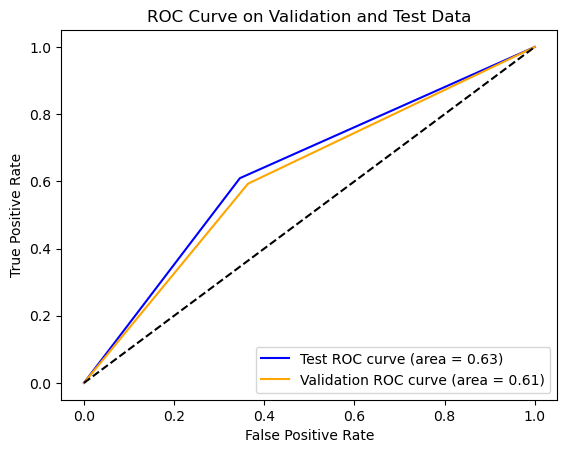

In [16]:
# Calculate ROC curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

print(f'''Val -
fpr_val: {fpr_val}
tpr_val: {tpr_val}
AUC_val: {roc_auc_val}''')

print(f'''Test -
fpr_test: {fpr_test}
tpr_test: {tpr_test}
AUC_test: {roc_auc_test}''')



plt.figure()

# Plot the ROC curve of testing
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test, color='blue')
plt.plot(fpr_val, tpr_val, label='Validation ROC curve (area = %0.2f)' % roc_auc_val, color='orange')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation and Test Data')
plt.legend(loc="lower right")
plt.show()
